Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

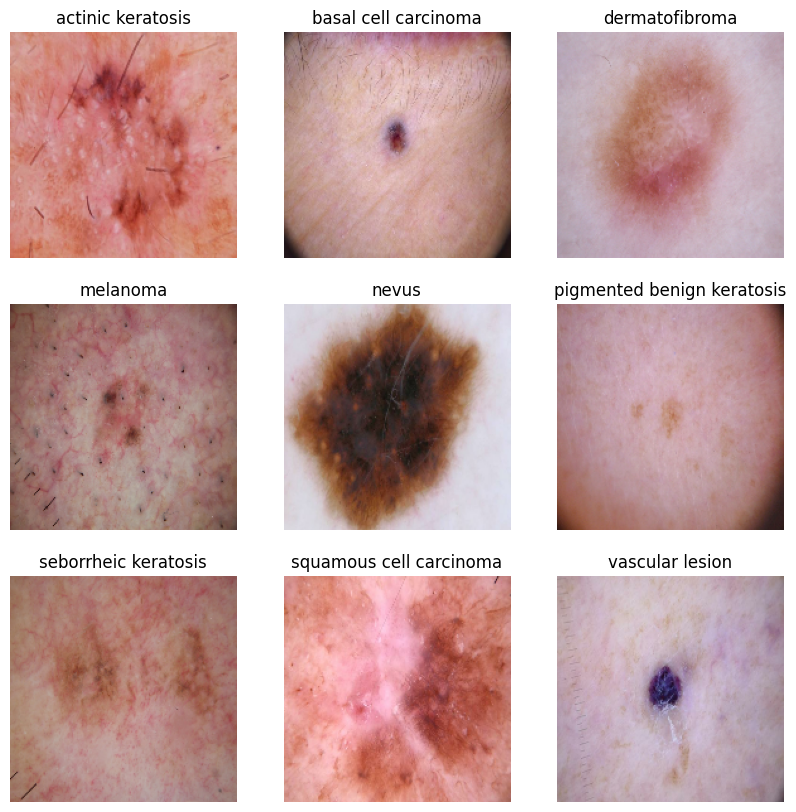

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation="softmax")
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 646s 2s/step - loss: 2.1529 - accuracy: 0.1680 - val_loss: 2.0198 - val_accuracy: 0.3043
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 2.0144 - accuracy: 0.2277 - val_loss: 1.9445 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8540 - accuracy: 0.3343 - val_loss: 1.6937 - val_accuracy: 0.4049
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5077 - accuracy: 0.4693 - val_loss: 1.4970 - val_accuracy: 0.4810
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3997 - accuracy: 0.5162 - val_loss: 1.4875 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3275 - accuracy: 0.5324 - val_loss: 1.4257 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2006 - accuracy: 0.5720 - val_loss: 1.3836 - val_accuracy: 0.5190
Epoch 8/20
56/56 [======

### Visualizing training results

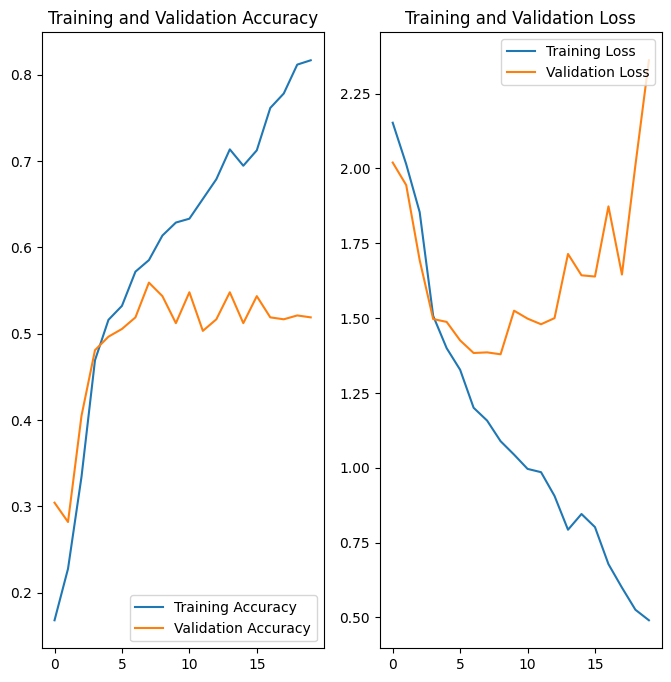

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 50% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

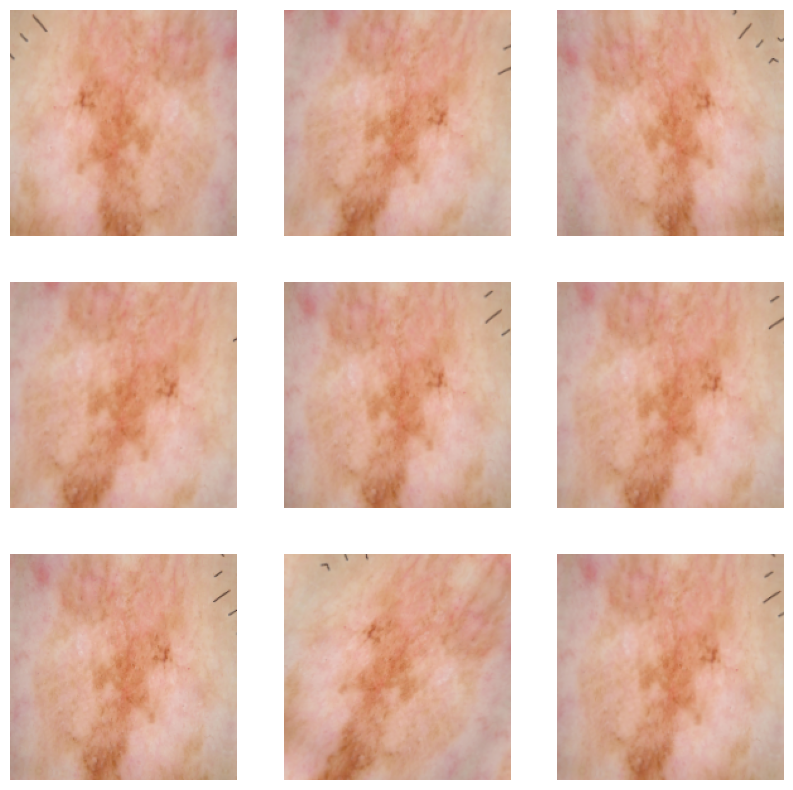

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



### Compiling the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [21]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 32ms/step - loss: 1.8670 - accuracy: 0.3259 - val_loss: 1.6245 - val_accuracy: 0.4564
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5745 - accuracy: 0.4425 - val_loss: 1.5369 - val_accuracy: 0.4631
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4383 - accuracy: 0.4810 - val_loss: 1.4514 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3725 - accuracy: 0.5223 - val_loss: 1.4077 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3492 - accuracy: 0.5151 - val_loss: 1.3855 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2858 - accuracy: 0.5363 - val_loss: 1.3931 - val_accuracy: 0.5615
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2312 - accuracy: 0.5525 - val_loss: 1.3606 - val_accuracy: 0.5369
Epoch 8/20
56

### Visualizing the results

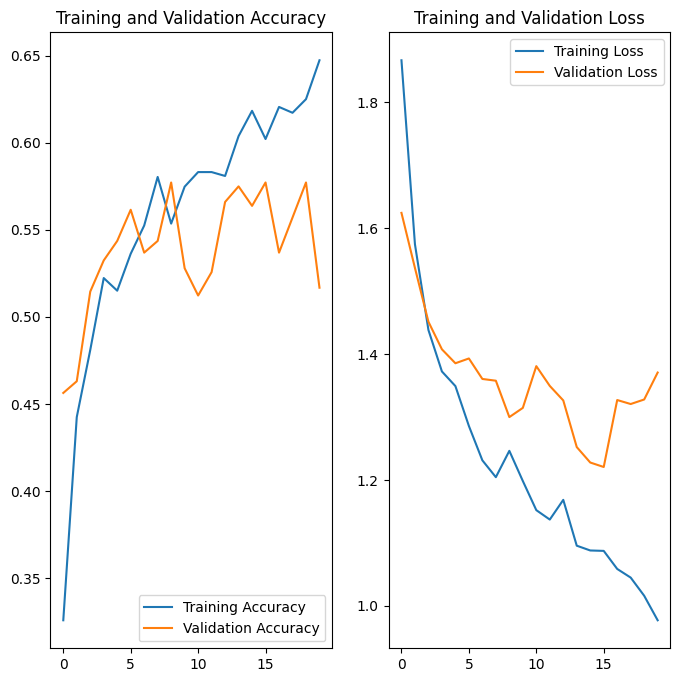

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Although the accuracy is not high, but overfitting has reduced and there is an improvement from the run model. But overfitting is still there

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
## Your code goes here.

@tf.function
def count_class(counts, batch):
    y, _, c = tf.unique_with_counts(batch[1])
    return tf.tensor_scatter_nd_add(counts, tf.expand_dims(y, axis=1), c)

counts = train_ds.reduce(
    initial_state=tf.zeros(num_classes, tf.int32),
    reduce_func=count_class)

for c in zip(class_names,list(counts.numpy())):
  print(c)

('actinic keratosis', 92)
('basal cell carcinoma', 309)
('dermatofibroma', 77)
('melanoma', 352)
('nevus', 277)
('pigmented benign keratosis', 370)
('seborrheic keratosis', 58)
('squamous cell carcinoma', 142)
('vascular lesion', 115)


According to the distribution, **actinic keratosis** has the least number of samples.
And **pigmented benign keratosis** currently dominate the data in terms of proportionate number of samples.

#### Rectify the class imbalance
#### **Context:** Used a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EEC804D7610>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EEB5D062410>: 100%|██████████| 500/500 [00:19<00:00, 25.03 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EEBED056E30>: 100%|██████████| 500/500 [00:18<00:00, 27.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EEC8048F250>: 100%|██████████| 500/500 [01:18<00:00,  6.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EEB9815D570>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EEBED056410>: 100%|██████████| 500/500 [00:17<00:00, 28.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EEB807C0070>: 100%|██████████| 500/500 [00:36<00:00, 13.55 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EEB5D31F280>: 100%|██████████| 500/500 [00:17<00:00, 28.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EEB9B9B6A70>: 100%|██████████| 500/500 [00:17<00:00, 28.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
import glob

In [38]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011151.jpg_2af9bbb7-0071-4906-af99-cd5659ead33c.jpg',
 '/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011178.jpg_08cf57a6-6195-4c1a-b28f-fb96f213787c.jpg',
 '/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_f3ead8b4-af34-44d4-a573-6666dff674e5.jpg',
 '/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010876.jpg_196b51c2-3fb8-4624-a9ec-1e74e0c3598a.jpg',
 '/content/gdrive/My

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.DataFrame(train_ds).append(df2)

<ipython-input-46-c4a1ece76753>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = pd.DataFrame(train_ds).append(df2)


In [48]:
new_df['Label'].value_counts()

seborrheic keratosis          500
melanoma                      500
basal cell carcinoma          500
nevus                         500
squamous cell carcinoma       500
actinic keratosis             500
vascular lesion               500
dermatofibroma                500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [53]:
data_dir_train="/content/gdrive/MyDrive/ML/CNN_Assignment/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model

In [55]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compile the model

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### Train your model

In [58]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 42s 232ms/step - loss: 1.9471 - accuracy: 0.2717 - val_loss: 1.5946 - val_accuracy: 0.3846
Epoch 2/50
169/169 [==============================] - 38s 216ms/step - loss: 1.5114 - accuracy: 0.4338 - val_loss: 1.4755 - val_accuracy: 0.4417
Epoch 3/50
169/169 [==============================] - 38s 218ms/step - loss: 1.4123 - accuracy: 0.4707 - val_loss: 1.3614 - val_accuracy: 0.4796
Epoch 4/50
169/169 [==============================] - 40s 232ms/step - loss: 1.3463 - accuracy: 0.4980 - val_loss: 1.3783 - val_accuracy: 0.4922
Epoch 5/50
169/169 [==============================] - 38s 217ms/step - loss: 1.2779 - accuracy: 0.5141 - val_loss: 1.3058 - val_accuracy: 0.5004
Epoch 6/50
169/169 [==============================] - 38s 213ms/step - loss: 1.2353 - accuracy: 0.5371 - val_loss: 1.2791 - val_accuracy: 0.5241
Epoch 7/50
169/169 [==============================] - 38s 218ms/step - loss: 1.1991 - accuracy: 0.5462 - val_loss: 1.2054 - val_ac

#### Visualize the model results

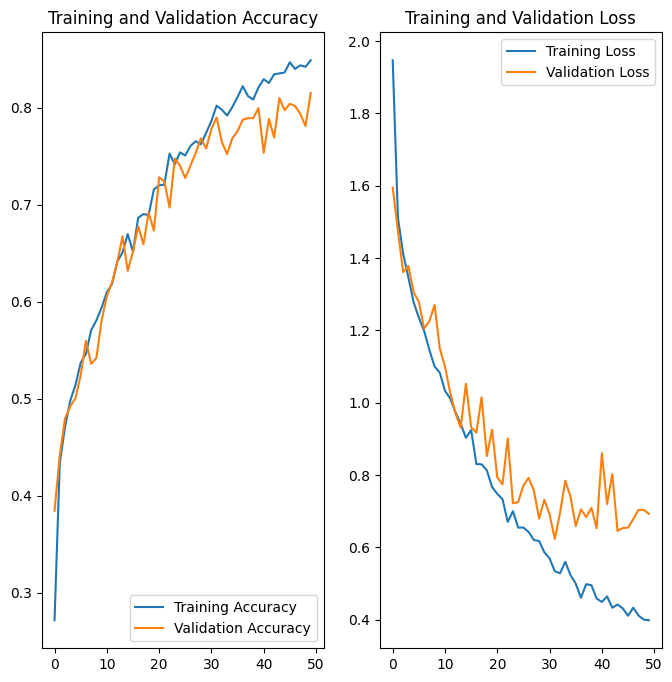

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We got rid of overfitting. The class rebalance helped in getting rid of the overfitting and also increased the accuracy.

